# Image Segmentation

Types of image segmentation:
1. Simple Thresholding
2. Adaptive Thresholding
3. K - Means Clustering Algorithm
4. Watershed Algorithm 

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Simple Thresholding

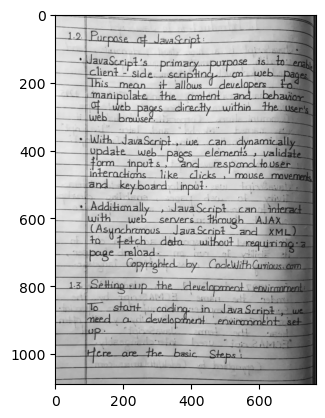

In [3]:
image = cv2.imread("../images/handwritten.jpg", 0) # 0 - changing image to grayscale
plt.imshow(image, cmap="gray")


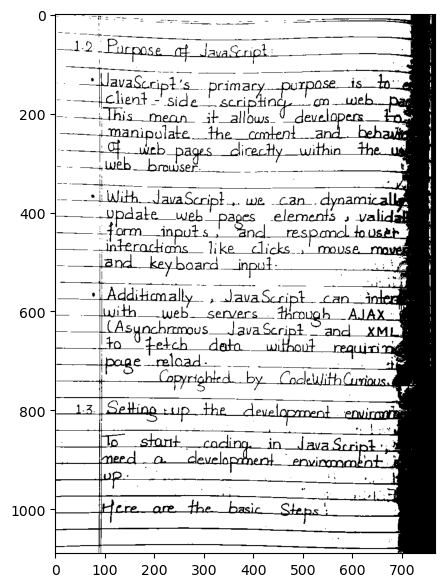

In [4]:
ret, binary = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY) # (threshold, values to replace, replace if pixels are greater than 150)

plt.figure(figsize=(12,7))
plt.imshow(binary, cmap="gray")
plt.show()

## Adaptive Thresholding

introduce noise
1. mean - mean of local region - constant(to adjust the values)
2. gaussian - weighted sum of local regions - constant

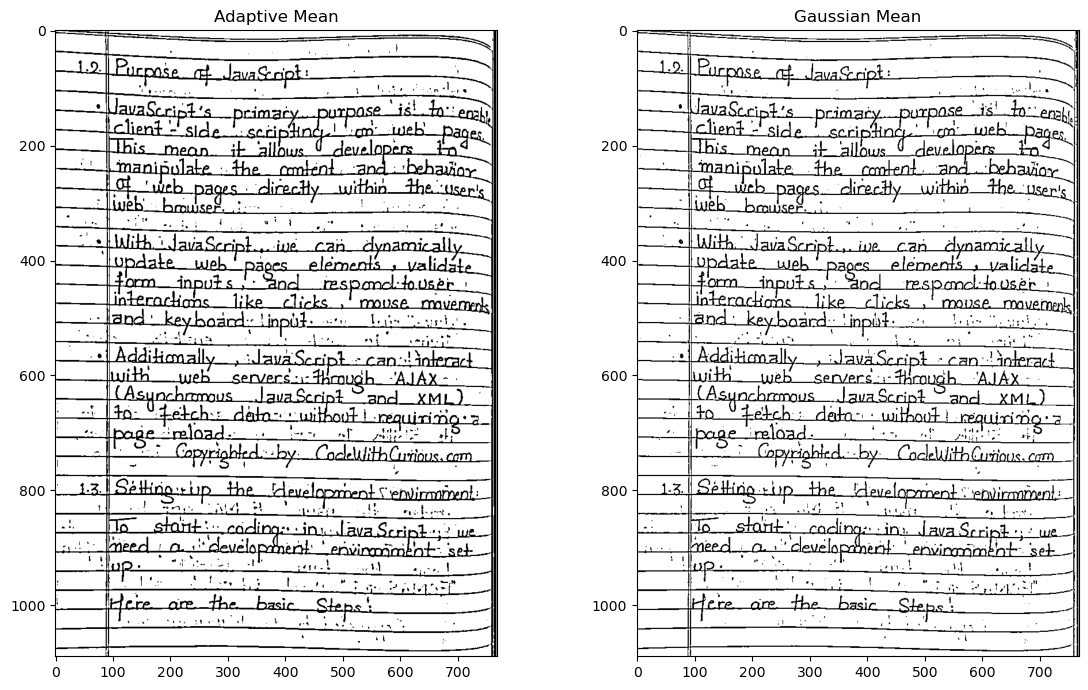

In [5]:
adaptive_m = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 9) # 11- block size, 9 - constant 
adaptive_g = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 9) # lesser constant value more the noise 

plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(adaptive_m, cmap="gray") # mean gives lot of noise  
plt.title("Adaptive Mean")

plt.subplot(1,2,2)
plt.imshow(adaptive_g,cmap="gray") # gaussian gives less noise comapred to mean
plt.title("Gaussian Mean")

plt.tight_layout()
plt.show()


## K - Mean Clustering

In [ ]:
image = cv2.imread("../images/shapes.jpg")
img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixels = image.reshape((-1,3)) # flatenning the image 
print(pixels) # unsigned integer 8 
pixels_float = np.float32(pixels)
print(pixels_float)

[[255 255 255]
 [255 255 255]
 [255 255 255]
 ...
 [255 255 255]
 [255 255 255]
 [255 255 255]]
[[255. 255. 255.]
 [255. 255. 255.]
 [255. 255. 255.]
 ...
 [255. 255. 255.]
 [255. 255. 255.]
 [255. 255. 255.]]


In [16]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2) # stopping criteria -> TERM_CRITERIA_EPS = 0.2, if loss <=0.2 in iteration - stop k - mean, 
# maximum time the k - means has to run is 100 , stop while training
k = 3 # clustering intp group
_, labels, centers = cv2.kmeans(pixels_float, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS) # None = placeholders, 
# 10 = no. of times k means is going to execute different initializations to find best clustering, 
# random - how to define clusters when initializing algo eg., randomly 

In [17]:
print(labels.shape)
print(centers) # categorized into 3 

(73360, 1)
[[246.09143  242.79582  252.54623 ]
 [ 19.142101 197.67491  249.86143 ]
 [108.6481    98.17311  114.67938 ]]


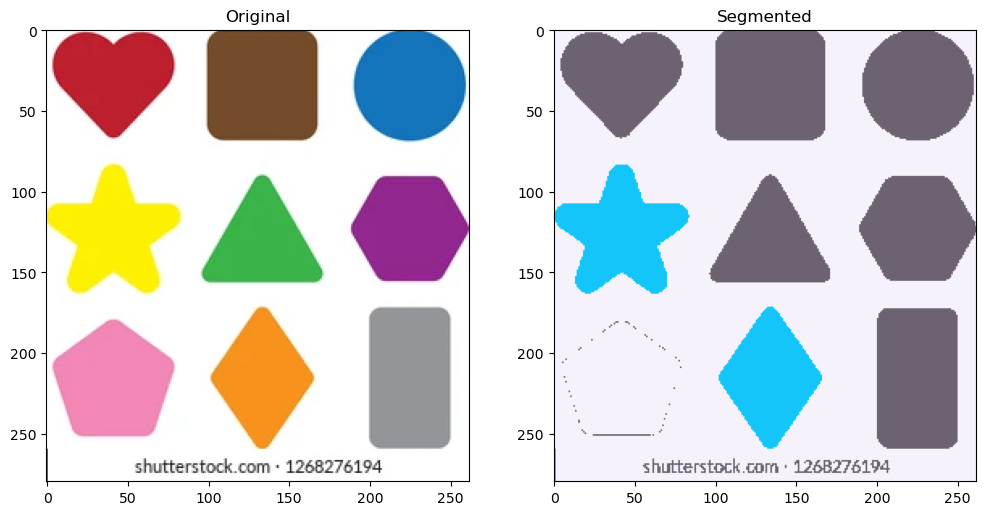

In [18]:
centers = np.uint8(centers)
segemented_image = centers[labels.flatten()]
segemented_image = segemented_image.reshape(img_rgb.shape)

plt.figure(figsize=(12,7))

plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(segemented_image)
plt.title("Segmented")

plt.show()


## Watershed algorithm 

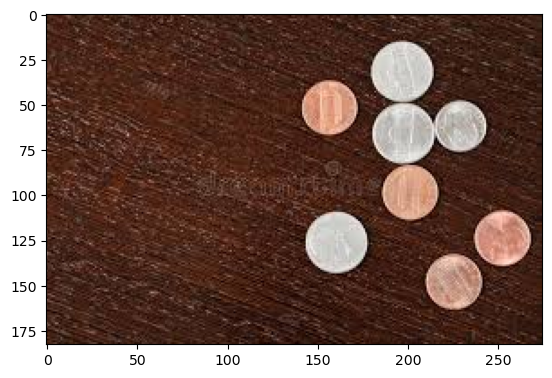

In [329]:
image = cv2.imread("../images/coins2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
original_image = image.copy()
plt.imshow(image)

Step 1: Convert the image to grayscale

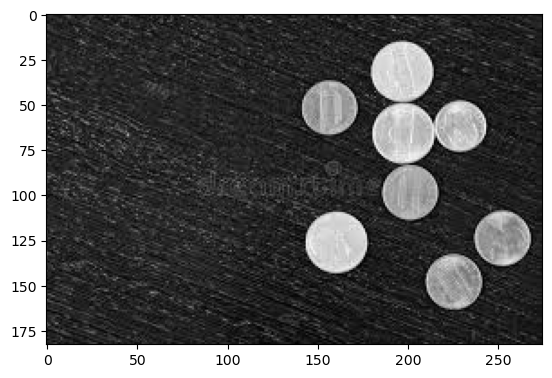

In [331]:
grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(grey, cmap = "gray")

Step 2: Create mask from grayscale image

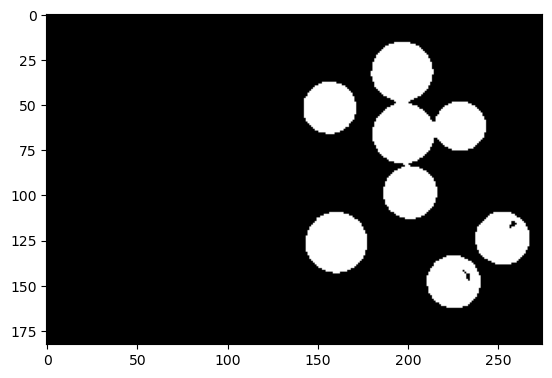

In [332]:
blur = cv2.GaussianBlur(grey, (5,5), 0)
_, threshold = cv2.threshold(blur, 130, 255, cv2.THRESH_BINARY ) # pixels less than 130 replace it with 255, else 0 
plt.imshow(threshold, cmap="grey")

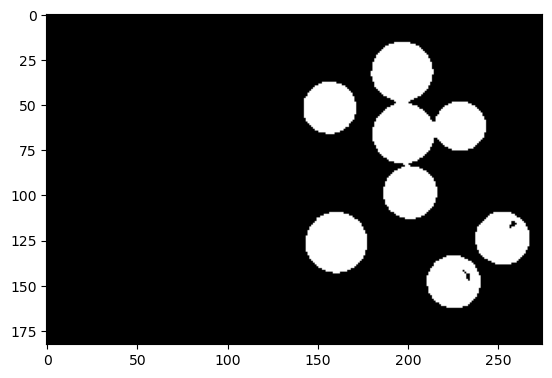

In [333]:
kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel, iterations=1) # removes noise from image 
plt.imshow(opening, cmap="gray")

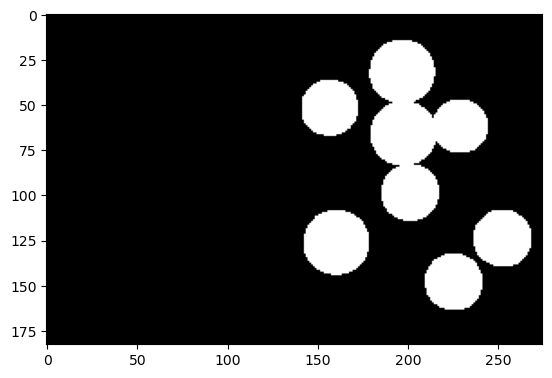

In [334]:
sure_bg = cv2.dilate(opening, kernel, iterations=1 ) # helps tp get bg 
plt.imshow(sure_bg, cmap="gray")

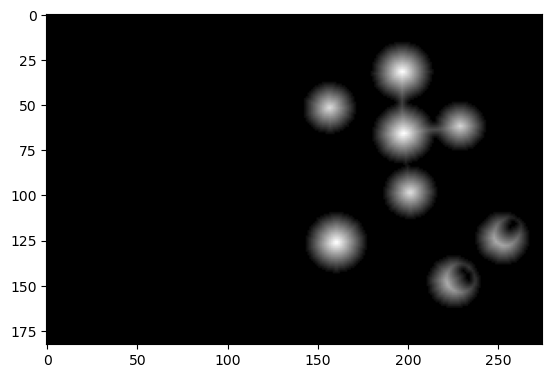

In [335]:
distance_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 0) # 7 -> mask size smaller size, faster computation but result in less accurate distance
plt.imshow(distance_transform, cmap="gray")

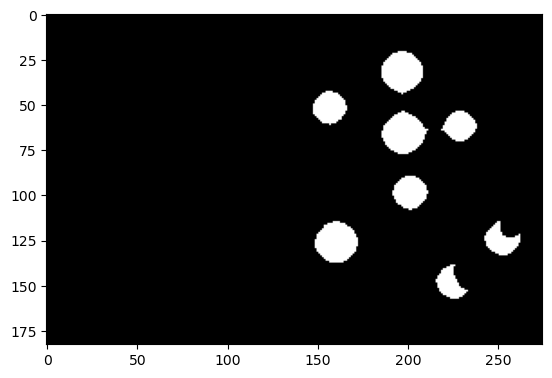

In [336]:
_, sure_fg = cv2.threshold(distance_transform, 0.35*distance_transform.max(), 255, 0) # 0.7*distance_transform.max() = bg, below value must be replaced with 0, above 255 
sure_fg = np.uint8(sure_fg)
plt.imshow(sure_fg, cmap="gray")

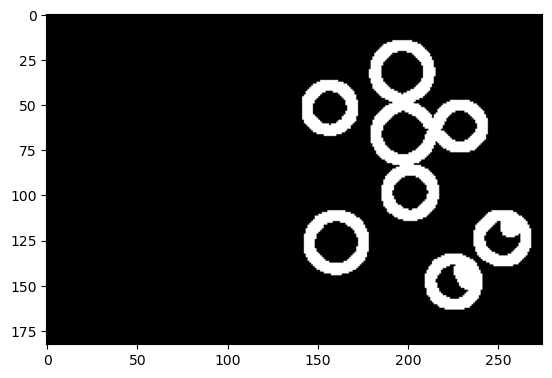

In [337]:
unknown_region = cv2.subtract(sure_bg, sure_fg)
plt.imshow(unknown_region, cmap="gray")

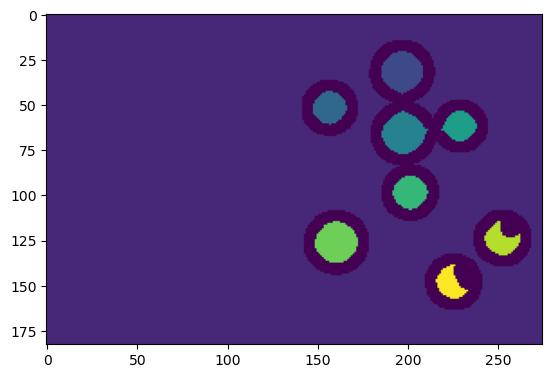

In [338]:
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown_region == 255] = 0 

plt.imshow(markers)

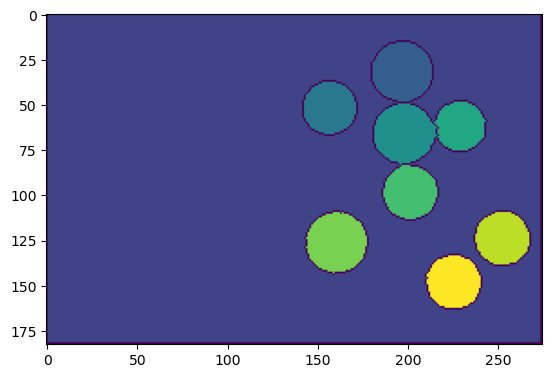

In [339]:
markers = cv2.watershed(image, markers)
plt.imshow(markers)

In [340]:
coins_mask = np.uint8(markers > 1) * 255
print(grey.shape)
print(coins_mask.shape)

uni_labels = np.unique(markers)

instance_no = 1
font = cv2.FONT_HERSHEY_SIMPLEX

for label in uni_labels:
    if label == 0 or label == -1:
        continue

    mask = np.uint8(markers == label)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if perimeter == 0:
            continue

        circularity = 4 * np.pi * (area/(perimeter * perimeter)) # checlonh circular section 

        if 0.7 < circularity < 1.2 and area >300:
            cv2.drawContours(original_image, [contour], -1, (0,255,0), 2)
            x, y, w, h = cv2.boundingRect(contour)
            h_img, w_img = original_image.shape[:2]
            margin = 5

            label = f"Coin{instance_no}"
            (font_w, font_h), baseline = cv2.getTextSize(label, font, 0.6, 1)

            # start where you already place it
            tx = x + 3
            ty = y + font_h + 3

            # clamp X so right side doesn't go out
            tx = max(margin, min(tx, w_img - font_w - margin))

            # if going above top, push it inside the coin box instead
            # if ty - font_h < margin:
            #     ty = y + font_h + margin

            # clamp Y so it stays inside bottom too
            ty = max(font_h + margin, min(ty, h_img - margin))

            cv2.putText(original_image, label, (tx, ty), font, 0.6, (0,0,0), 1, cv2.LINE_AA)
            cv2.putText(original_image, label, (tx, ty), font, 0.6, (127,200,132), 1,cv2.LINE_AA)
            #coins_mask = cv2.bitwise_or(coins_mask, mask)
            cv2.rectangle(original_image, (x-5, y -5),(x+w+5, y+h+5), (160, 150, 250),2 )
            instance_no += 1


(183, 275)
(183, 275)


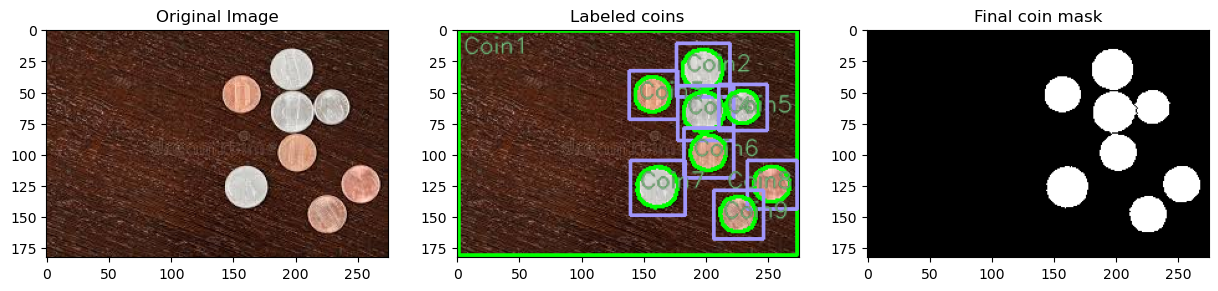

In [341]:
plt.figure(figsize=(15,10))

plt.subplot(1,3,1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(original_image)
plt.title("Labeled coins")

plt.subplot(1,3,3)
plt.imshow(coins_mask, cmap="gray")
plt.title("Final coin mask")

plt.show()


In [318]:
labels = np.unique(markers)
coins = [l for l in labels if l > 1]
print("coin labels:", coins)
print("coin count:", len(coins))



coin labels: [np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9)]
coin count: 8
